In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

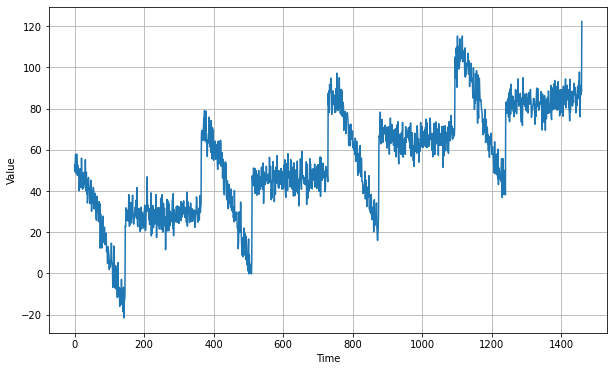

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 4s 32ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 87.1197 - mae: 87.6191
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 85.9241 - mae: 86.4235
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 84.3720 - mae: 84.8713
Epoch 5/100
8/8 [==============================] - 0s 26ms/step - loss: 82.4703 - mae: 82.9696
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 80.2434 - mae: 80.7428
Epoch 7/100
8/8 [==============================] - 0s 26ms/step - loss: 77.7459 - mae: 78.2453
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 75.0957 - mae: 75.5952
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 72.4508 - mae: 72.9504
Epoch 10/100
8/8 [==============================] - 0s 27ms/step - loss: 69.8938 - mae: 70.3934
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 26ms/step - loss: 14.8748 - mae: 15.3696
Epoch 88/100
8/8 [==============================] - 0s 25ms/step - loss: 14.0138 - mae: 14.5063
Epoch 89/100
8/8 [==============================] - 0s 25ms/step - loss: 11.3252 - mae: 11.8166
Epoch 90/100
8/8 [==============================] - 0s 25ms/step - loss: 23.7816 - mae: 24.2781
Epoch 91/100
8/8 [==============================] - 0s 27ms/step - loss: 21.4674 - mae: 21.9633
Epoch 92/100
8/8 [==============================] - 0s 27ms/step - loss: 23.5312 - mae: 24.0277
Epoch 93/100
8/8 [==============================] - 0s 29ms/step - loss: 15.0465 - mae: 15.5403
Epoch 94/100
8/8 [==============================] - 0s 27ms/step - loss: 12.2173 - mae: 12.7076
Epoch 95/100
8/8 [==============================] - 0s 26ms/step - loss: 16.1491 - mae: 16.6417
Epoch 96/100
8/8 [==============================] - 0s 25ms/step - loss: 15.4875 - mae: 15.9808
Epoch 97/100
8/8 [==============================] - 0

(1e-08, 0.0001, 0.0, 30.0)

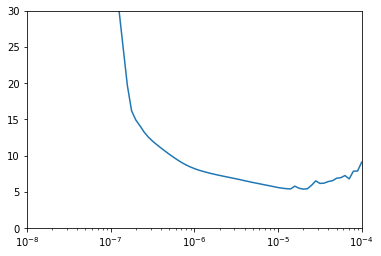

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
8/8 [==============================] - 4s 157ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 40ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 17.3630 - mae: 17.8585 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 37ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 39ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 1s 65ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 1s 62ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 1s 48ms/step - 

8/8 [==============================] - 0s 38ms/step - loss: 4.5189 - mae: 4.9947 - val_loss: 6.3860 - val_mae: 6.8701
Epoch 64/500
8/8 [==============================] - 0s 37ms/step - loss: 4.5203 - mae: 4.9967 - val_loss: 6.6531 - val_mae: 7.1365
Epoch 65/500
8/8 [==============================] - 0s 37ms/step - loss: 4.5504 - mae: 5.0274 - val_loss: 5.9734 - val_mae: 6.4555
Epoch 66/500
8/8 [==============================] - 0s 36ms/step - loss: 4.5614 - mae: 5.0384 - val_loss: 6.2281 - val_mae: 6.7109
Epoch 67/500
8/8 [==============================] - 0s 38ms/step - loss: 4.5188 - mae: 4.9957 - val_loss: 6.5304 - val_mae: 7.0145
Epoch 68/500
8/8 [==============================] - 0s 37ms/step - loss: 4.5129 - mae: 4.9895 - val_loss: 6.1017 - val_mae: 6.5841
Epoch 69/500
8/8 [==============================] - 0s 37ms/step - loss: 4.4907 - mae: 4.9673 - val_loss: 6.2080 - val_mae: 6.6916
Epoch 70/500
8/8 [==============================] - 0s 38ms/step - loss: 4.4814 - mae: 4.9571 - 

8/8 [==============================] - 0s 41ms/step - loss: 4.2980 - mae: 4.7725 - val_loss: 5.6938 - val_mae: 6.1760
Epoch 126/500
8/8 [==============================] - 0s 37ms/step - loss: 4.2996 - mae: 4.7740 - val_loss: 5.6642 - val_mae: 6.1458
Epoch 127/500
8/8 [==============================] - 0s 38ms/step - loss: 4.2928 - mae: 4.7677 - val_loss: 5.7806 - val_mae: 6.2631
Epoch 128/500
8/8 [==============================] - 0s 37ms/step - loss: 4.2913 - mae: 4.7661 - val_loss: 5.5420 - val_mae: 6.0215
Epoch 129/500
8/8 [==============================] - 0s 38ms/step - loss: 4.2916 - mae: 4.7659 - val_loss: 5.6050 - val_mae: 6.0865
Epoch 130/500
8/8 [==============================] - 0s 38ms/step - loss: 4.2933 - mae: 4.7673 - val_loss: 5.7361 - val_mae: 6.2186
Epoch 131/500
8/8 [==============================] - 0s 38ms/step - loss: 4.2942 - mae: 4.7688 - val_loss: 5.6332 - val_mae: 6.1152
Epoch 132/500
8/8 [==============================] - 0s 37ms/step - loss: 4.2888 - mae: 4.

8/8 [==============================] - 0s 38ms/step - loss: 4.1816 - mae: 4.6547 - val_loss: 5.5437 - val_mae: 6.0255
Epoch 188/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1780 - mae: 4.6512 - val_loss: 5.3175 - val_mae: 5.7971
Epoch 189/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1821 - mae: 4.6557 - val_loss: 5.4117 - val_mae: 5.8923
Epoch 190/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1827 - mae: 4.6560 - val_loss: 5.3709 - val_mae: 5.8512
Epoch 191/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1821 - mae: 4.6561 - val_loss: 5.6392 - val_mae: 6.1212
Epoch 192/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1799 - mae: 4.6537 - val_loss: 5.5044 - val_mae: 5.9861
Epoch 193/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1768 - mae: 4.6500 - val_loss: 5.6970 - val_mae: 6.1785
Epoch 194/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1734 - mae: 4.

8/8 [==============================] - 0s 38ms/step - loss: 4.1207 - mae: 4.5923 - val_loss: 5.2881 - val_mae: 5.7687
Epoch 250/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1206 - mae: 4.5931 - val_loss: 5.3460 - val_mae: 5.8267
Epoch 251/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1197 - mae: 4.5919 - val_loss: 5.2538 - val_mae: 5.7333
Epoch 252/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1180 - mae: 4.5904 - val_loss: 5.1683 - val_mae: 5.6473
Epoch 253/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1136 - mae: 4.5853 - val_loss: 5.1592 - val_mae: 5.6377
Epoch 254/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1226 - mae: 4.5953 - val_loss: 5.1759 - val_mae: 5.6543
Epoch 255/500
8/8 [==============================] - 0s 37ms/step - loss: 4.1132 - mae: 4.5852 - val_loss: 5.3377 - val_mae: 5.8188
Epoch 256/500
8/8 [==============================] - 0s 38ms/step - loss: 4.1097 - mae: 4.

8/8 [==============================] - 0s 38ms/step - loss: 4.0843 - mae: 4.5560 - val_loss: 5.3266 - val_mae: 5.8076
Epoch 312/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0888 - mae: 4.5603 - val_loss: 5.0733 - val_mae: 5.5525
Epoch 313/500
8/8 [==============================] - 0s 39ms/step - loss: 4.1018 - mae: 4.5742 - val_loss: 5.0707 - val_mae: 5.5481
Epoch 314/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0932 - mae: 4.5649 - val_loss: 5.1205 - val_mae: 5.5993
Epoch 315/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0764 - mae: 4.5474 - val_loss: 5.3246 - val_mae: 5.8055
Epoch 316/500
8/8 [==============================] - 0s 37ms/step - loss: 4.0818 - mae: 4.5535 - val_loss: 5.3328 - val_mae: 5.8138
Epoch 317/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0877 - mae: 4.5600 - val_loss: 5.2711 - val_mae: 5.7516
Epoch 318/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0710 - mae: 4.

8/8 [==============================] - 0s 38ms/step - loss: 4.0490 - mae: 4.5200 - val_loss: 5.0127 - val_mae: 5.4916
Epoch 374/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0529 - mae: 4.5234 - val_loss: 5.1369 - val_mae: 5.6166
Epoch 375/500
8/8 [==============================] - 0s 39ms/step - loss: 4.0751 - mae: 4.5466 - val_loss: 5.5700 - val_mae: 6.0499
Epoch 376/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0958 - mae: 4.5684 - val_loss: 5.3624 - val_mae: 5.8433
Epoch 377/500
8/8 [==============================] - 0s 42ms/step - loss: 4.0638 - mae: 4.5351 - val_loss: 5.2859 - val_mae: 5.7661
Epoch 378/500
8/8 [==============================] - 0s 38ms/step - loss: 4.0521 - mae: 4.5230 - val_loss: 5.2590 - val_mae: 5.7397
Epoch 379/500
8/8 [==============================] - 0s 39ms/step - loss: 4.0671 - mae: 4.5387 - val_loss: 5.3635 - val_mae: 5.8448
Epoch 380/500
8/8 [==============================] - 0s 39ms/step - loss: 4.0652 - mae: 4.

In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

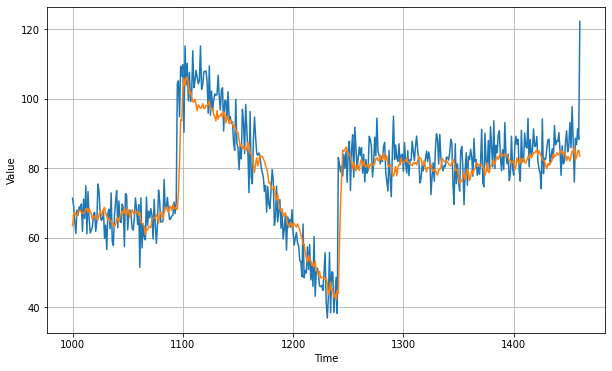

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.112561

# Fully CNN

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/home/nikhil/anaconda3/envs/deepl/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 [==============================] - 2s 27ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 25ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 36.6836 - mae: 37.1823
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 33.3644 - mae: 33.8629
Epoch 10/100
8/8 [==============================] - 0s 30ms/step - loss: 27.9450 - mae: 28.4427
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 26ms/step - loss: 7.4478 - mae: 7.9329
Epoch 88/100
8/8 [==============================] - 0s 26ms/step - loss: 8.6604 - mae: 9.1479
Epoch 89/100
8/8 [==============================] - 0s 27ms/step - loss: 8.1790 - mae: 8.6657
Epoch 90/100
8/8 [==============================] - 0s 25ms/step - loss: 8.2852 - mae: 8.7717
Epoch 91/100
8/8 [==============================] - 0s 26ms/step - loss: 8.2631 - mae: 8.7508
Epoch 92/100
8/8 [==============================] - 0s 25ms/step - loss: 7.0946 - mae: 7.5788
Epoch 93/100
8/8 [==============================] - 0s 26ms/step - loss: 9.4937 - mae: 9.9831
Epoch 94/100
8/8 [==============================] - 0s 25ms/step - loss: 10.3278 - mae: 10.8178
Epoch 95/100
8/8 [==============================] - 0s 26ms/step - loss: 9.5424 - mae: 10.0310
Epoch 96/100
8/8 [==============================] - 0s 28ms/step - loss: 26.6793 - mae: 27.1762
Epoch 97/100
8/8 [==============================] - 0s 27ms/step - l

(0.0001, 0.1, 0.0, 30.0)

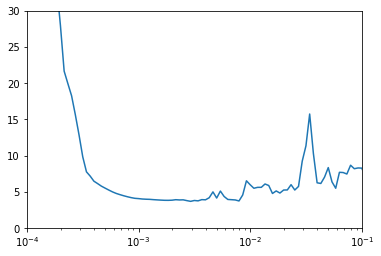

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 2s 88ms/step - loss: 40.1883 - mae: 40.6871 - val_loss: 72.9189 - val_mae: 73.4189
Epoch 2/500
8/8 [==============================] - 1s 50ms/step - loss: 38.1153 - mae: 38.6140 - val_loss: 67.9778 - val_mae: 68.4778
Epoch 3/500
8/8 [==============================] - 0s 41ms/step - loss: 35.1358 - mae: 35.6344 - val_loss: 60.8665 - val_mae: 61.3665
Epoch 4/500
8/8 [==============================] - 0s 45ms/step - loss: 30.8281 - mae: 31.3263 - val_loss: 50.2195 - val_mae: 50.7191
Epoch 5/500
8/8 [==============================] - 0s 43ms/step - loss: 24.9596 - mae: 25.4564 - val_loss: 36.6520 - val_mae: 37.1480
Epoch 6/500
8/8 [==============================] - 0s 38ms/step - loss: 20.1383 - mae: 20.6330 - val_loss: 32.0186 - val_mae: 32.5158
Epoch 7/500
8/8 [==============================] - 0s 39ms/step - loss: 18.8909 - mae: 19.3859 - val_loss: 30.0781 - val_mae: 30.5755
Epoch 8/500
8/8 [==============================] - 1s 61ms/ste

8/8 [==============================] - 0s 37ms/step - loss: 3.7912 - mae: 4.2610 - val_loss: 4.2354 - val_mae: 4.7096
Epoch 64/500
8/8 [==============================] - 0s 36ms/step - loss: 3.7850 - mae: 4.2549 - val_loss: 4.2372 - val_mae: 4.7117
Epoch 65/500
8/8 [==============================] - 0s 38ms/step - loss: 3.7797 - mae: 4.2497 - val_loss: 4.2503 - val_mae: 4.7252
Epoch 66/500
8/8 [==============================] - 0s 37ms/step - loss: 3.7745 - mae: 4.2442 - val_loss: 4.3018 - val_mae: 4.7789
Epoch 67/500
8/8 [==============================] - 0s 36ms/step - loss: 3.7754 - mae: 4.2451 - val_loss: 4.2576 - val_mae: 4.7329
Epoch 68/500
8/8 [==============================] - 0s 40ms/step - loss: 3.7631 - mae: 4.2324 - val_loss: 4.2091 - val_mae: 4.6835
Epoch 69/500
8/8 [==============================] - 0s 37ms/step - loss: 3.7549 - mae: 4.2239 - val_loss: 4.2985 - val_mae: 4.7758
Epoch 70/500
8/8 [==============================] - 0s 37ms/step - loss: 3.7535 - mae: 4.2226 - 

8/8 [==============================] - 0s 37ms/step - loss: 3.4937 - mae: 3.9559 - val_loss: 4.1999 - val_mae: 4.6758
Epoch 126/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4937 - mae: 3.9560 - val_loss: 4.2067 - val_mae: 4.6830
Epoch 127/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4889 - mae: 3.9509 - val_loss: 4.2665 - val_mae: 4.7434
Epoch 128/500
8/8 [==============================] - 0s 38ms/step - loss: 3.4851 - mae: 3.9464 - val_loss: 4.2132 - val_mae: 4.6889
Epoch 129/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4797 - mae: 3.9407 - val_loss: 4.1937 - val_mae: 4.6693
Epoch 130/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4780 - mae: 3.9389 - val_loss: 4.2467 - val_mae: 4.7231
Epoch 131/500
8/8 [==============================] - 0s 38ms/step - loss: 3.4739 - mae: 3.9345 - val_loss: 4.2577 - val_mae: 4.7334
Epoch 132/500
8/8 [==============================] - 0s 37ms/step - loss: 3.4709 - mae: 3.

In [15]:
model = keras.models.load_model("my_checkpoint.h5")

In [16]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

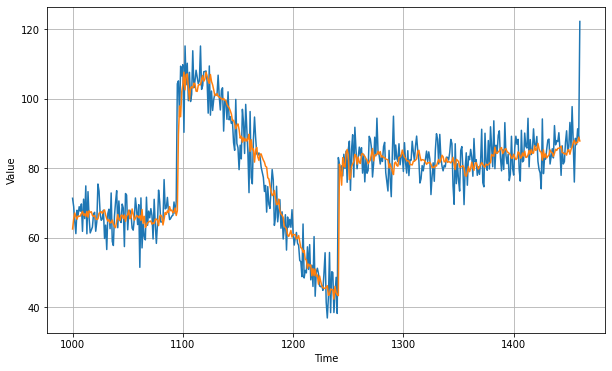

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [18]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.526851